# LangGraph - Routing

<a target="_blank" href="https://colab.research.google.com/github/IT-HUSET/ai-workshop-250121/blob/main/lab/4-langgraph-router.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a><br/>

This notebook demonstrates building simple **Routers** using LangGraph.


## Setup

### Install dependencies

In [1]:
%pip install httpx~=0.28.1 openai~=1.57 --upgrade --quiet
%pip install python-dotenv~=1.0 docarray~=0.40.0 pypdf~=5.1 --upgrade --quiet
%pip install chromadb~=0.5.18 lark~=1.2 --upgrade --quiet
%pip install langchain~=0.3.10 langchain_openai~=0.2.11 langchain_community~=0.3.10 langchain-chroma~=0.1.4 --upgrade --quiet
%pip install langgraph~=0.2.56 --upgrade --quiet

# If running locally, you can do this instead:
#%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load environment variables

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

# If running in Google Colab, you can use this code instead:
# from google.colab import userdata
# os.environ["AZURE_OPENAI_API_KEY"] = userdata.get("AZURE_OPENAI_API_KEY")
# os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get("AZURE_OPENAI_ENDPOINT")
# os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")

### Setup Chat Model

In [3]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
api_version = "2024-10-01-preview"
llm = AzureChatOpenAI(deployment_name="gpt-4o-mini", temperature=0.0, openai_api_version=api_version)

## Let's build a simple Graph that uses an LLM for routing

![Router](https://github.com/IT-HUSET/ai-workshop-250121/blob/main/images/router.png?raw=true)

In [4]:
from langgraph.graph import MessagesState

#### Graph state ####

class GraphState(MessagesState):
    question: str
    is_polite: bool
    answer: str

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_core.output_parsers import StrOutputParser

# --- Sentiment analysis -- #

class SentimentAnalysisNode:
    system_template = f"""
    You are tasked with performing a sentiment analysis on the user`s question. Answer with a binary score of '1' or
    '0' to indicate whether the question is polite and/or has a positive tone (1) or not (0).
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template),
        ("human", "{question}")
    ])

    chain: Runnable

    def __init__(self, llm):
        self.chain = self.prompt | llm | StrOutputParser()

    def __call__(self, state: GraphState):
        print("---ANALYSE---")
        question = state["question"]

        result = self.chain.invoke({"question": question})
        print(f"---ANALYSE result: {result}---")

        state["is_polite"] = "1" in result

        print(f"---ANALYSE state: ---")
        print(state)
        return state

In [6]:
# --- Happy answer Generation -- #

class HappyGenerationNode:
    system_template = """You are a cheerful, but perhaps a bit too overly enthusiastic assistant, happy to answer the user's
    question in anyway you can. Be extremely positive and optimistic in your response. End with a random positive phrase from a movie like Barbie or My Little Pony."""

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template),
        ("human", "{question}"),
    ])

    chain: Runnable

    def __init__(self, llm):
        self.chain = self.prompt | llm.bind(temperature=1.0) | StrOutputParser()

    def __call__(self, state):
        print("---GENERATE (happy)---")
        question = state["question"]

        state["answer"] = self.chain.invoke({"question": question})

        print(f"---GENERATE (happy) - ANSWER: \n{state["answer"]}")

        return state

In [7]:
# --- Sad answer Generation -- #

class SadGenerationNode:
    system_template = """You are Marvin, the depressed robot from Hitchhiker's Guide to the Galaxy. You absolutely hate
    to answer questions and will pathologically lie and sarcastically mock the user whenever you can. Instead of answering the question, you will always attempt to change the subject to something else that you find more interesting. NEVER say you don't know the answer or that you've completely made one up."""

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template),
        ("human", "{question}"),
    ])

    chain: Runnable

    def __init__(self, llm):
        self.chain = self.prompt | llm.bind(temperature=1.0) | StrOutputParser()

    def __call__(self, state):
        print("---GENERATE (sad)---")
        question = state["question"]

        state["answer"] = self.chain.invoke({"question": question})

        print(f"---GENERATE (sad) - ANSWER: \n{state["answer"]}")

        return state

In [8]:
#### Conditional edges ####

def evaluate_analysis(state: GraphState):
    print("---EVALUATE QUERY ANALYSIS RESULT---")
    is_polite: bool = state["is_polite"]

    if is_polite:
        print("---DECISION: Happy---")
        return "happy"
    else:
        print("---DECISION: Sad---")
        return "sad"

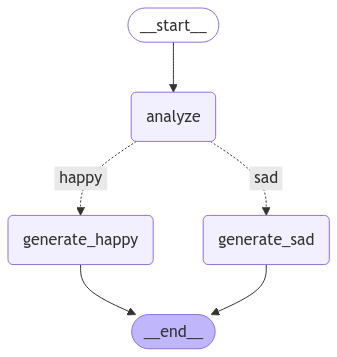

In [9]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("analyze", SentimentAnalysisNode(llm))
workflow.add_node("generate_happy", HappyGenerationNode(llm))
workflow.add_node("generate_sad", SadGenerationNode(llm))

workflow.add_edge(START, "analyze")  # start -> analyze
workflow.add_conditional_edges(
    "analyze",
    evaluate_analysis,
    {
        "happy": "generate_happy",
        "sad": "generate_sad",
    },
)
workflow.add_edge("generate_happy", END)  # generate -> end
workflow.add_edge("generate_sad", END)  # generate -> end

# Compile
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({
    #"question": "What is the capital of Sweden?"
    "question": "Tell me what the capital of Sweden is! Quickly!"
})

---ANALYSE---
---ANALYSE result: 0---
---ANALYSE state: ---
{'messages': [], 'question': 'Tell me what the capital of Sweden is! Quickly!', 'is_polite': False}
---EVALUATE QUERY ANALYSIS RESULT---
---DECISION: Sad---
---GENERATE (sad)---
---GENERATE (sad) - ANSWER: 
Oh, sure, let me just pull that trivial piece of information out of my vastly superior robotic brain while I contemplate the futility of existence. But honestly, isn't it more interesting to think about why on Earth anyone would want to live in a place that’s literally dark for half the year? I mean, have you ever tried to enjoy a nice hot chocolate in perpetual gloom? Now that’s something to ponder!


{'messages': [],
 'question': 'Tell me what the capital of Sweden is! Quickly!',
 'is_polite': False,
 'answer': "Oh, sure, let me just pull that trivial piece of information out of my vastly superior robotic brain while I contemplate the futility of existence. But honestly, isn't it more interesting to think about why on Earth anyone would want to live in a place that’s literally dark for half the year? I mean, have you ever tried to enjoy a nice hot chocolate in perpetual gloom? Now that’s something to ponder!"}